In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.util import read_data_chars, add_gpu_chars_to_df, read_gpu_chars, read_results
from src.analytical_model import load_X, LinRegEnsemble
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
df, dep, indep = load_X()
df.columns
inspect = df.head(1).T

2024-03-29 12:48:32.768 | INFO     | src.analytical_model:load_X:32 - Loading data for analytical model


2024-03-29 12:48:34.387 | INFO     | src.analytical_model:load_X:84 - Loaded data for analytical model with 24 dependent variables and 61 independent variables


In [3]:
sorted(indep)

['13',
 '14',
 '24',
 '25',
 'FR',
 'TR',
 'c_T',
 'cardinality_S',
 'cardinality_T',
 'comp_colsum',
 'comp_fac',
 'comp_fac_col_major',
 'comp_lmm_fac',
 'comp_lmm_mat',
 'comp_mat',
 'comp_mat_col_major',
 'comp_matrix_dense',
 'comp_ratio',
 'comp_rmm_fac',
 'comp_rmm_mat',
 'comp_rowsum',
 'comp_scalar_dense',
 'comp_scalar_fac',
 'comp_scalar_mat',
 'complexity_ratio',
 'fr',
 'gpu__cores',
 'gpu__number_of_sm',
 'gpu_cache_size_l1',
 'gpu_cache_size_l2',
 'gpu_clock_speed_base',
 'gpu_clock_speed_max_boost',
 'gpu_memory_bandwidth',
 'gpu_memory_bus_width',
 'gpu_memory_clock',
 'gpu_memory_size',
 'gpu_processing_power_double_precision',
 'gpu_processing_power_half_precision',
 'gpu_processing_power_single_precision',
 'mem_fac_read',
 'mem_fac_write',
 'mem_mat_read',
 'mem_mat_write',
 'mem_read_colsum',
 'mem_read_matrix_dense',
 'mem_read_rowsum',
 'mem_read_scalar_dense',
 'mem_write_colsum',
 'mem_write_matrix_dense',
 'mem_write_rowsum',
 'mem_write_scalar_dense',
 'morp

### Option , Lin Reg ensemble
- predict 'memory_throughput_byte_weighted_mean', 'dram_bytes_sum' separately
- single regressor per (type, operator, ycol)

Separate prediction for bytes sum and throughput bytes

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df[indep]), index=df.index, columns=indep)
y = df[dep]

train, test = train_test_split(df, test_size=0.3, random_state=42)
X_train = X.loc[train.index]
X_test = X.loc[test.index]
y_train = y.loc[train.index]
y_test = y.loc[test.index]

def create_and_eval_model(targets, target_to_pred_func, split_by=["operator", "model"]):
    model = LinRegEnsemble(
        train,
        X_train,
        y_train[targets],
        LinearRegression,
        split_by=split_by,
        target_to_pred_func=target_to_pred_func, 
        # clf_kwargs={"positive": True, }
    )

    pred = model.predict(test, X_test)
    y_true = target_to_pred_func(y_test)
    ax = sns.scatterplot(x=y_true,y= pred)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(f"targets: {targets}\nmse: {mean_squared_error(y_true, pred): .4f}")
    ax.plot([0,10],[0,10], color='red')
    ax.set_xlabel("True value")
    ax.set_xlabel("Predicted value")
    return model

2024-03-29 12:48:34.636 | INFO     | src.analytical_model:create_linreg_ensemble:181 - Creating a linear regression ensemble for the analytical model, splitting by ['operator', 'model']


2024-03-29 12:48:43.656 | INFO     | src.analytical_model:create_linreg_ensemble:209 - Created a linear regression ensemble for the analytical model with 48 models
2024-03-29 12:48:43.657 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


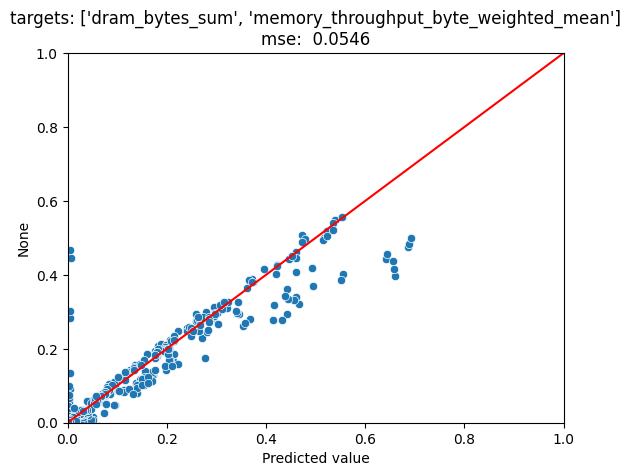

In [5]:

targets = ["dram_bytes_sum", "memory_throughput_byte_weighted_mean"]
analytical1 = create_and_eval_model(targets, lambda x: x.dram_bytes_sum / x.memory_throughput_byte_weighted_mean)

Separate prediction for bytes_read, bytes_write, throughput_sum

2024-03-29 12:48:43.947 | INFO     | src.analytical_model:create_linreg_ensemble:181 - Creating a linear regression ensemble for the analytical model, splitting by ['operator', 'model']


2024-03-29 12:48:55.555 | INFO     | src.analytical_model:create_linreg_ensemble:209 - Created a linear regression ensemble for the analytical model with 72 models
2024-03-29 12:48:55.556 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


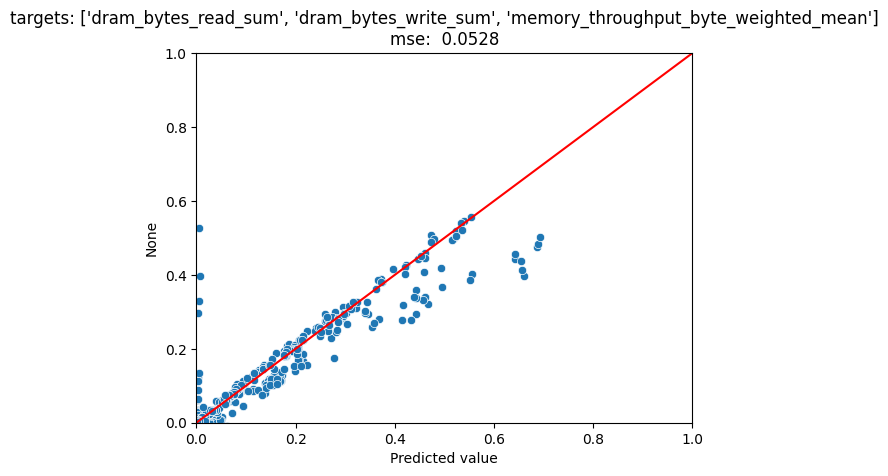

In [6]:
targets = ['dram_bytes_read_sum', 'dram_bytes_write_sum', 'memory_throughput_byte_weighted_mean']
analytical2 = create_and_eval_model(targets, lambda x: (x.dram_bytes_read_sum + x.dram_bytes_write_sum) / x.memory_throughput_byte_weighted_mean)

2024-03-29 12:48:55.902 | INFO     | src.analytical_model:create_linreg_ensemble:181 - Creating a linear regression ensemble for the analytical model, splitting by ['operator', 'model']


2024-03-29 12:48:59.753 | INFO     | src.analytical_model:create_linreg_ensemble:209 - Created a linear regression ensemble for the analytical model with 24 models
2024-03-29 12:48:59.753 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


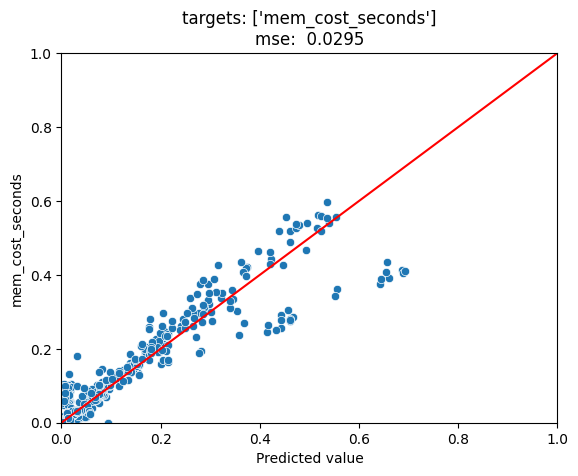

In [7]:
targets = ['mem_cost_seconds']
analytical3 = create_and_eval_model(targets, lambda x: (x.mem_cost_seconds))

## Predict cost for train data

In [12]:
from src.analytical_model import ModelCost
from src.util import model_operators, train_test_validate_split
import threading

results_df = read_results()

results_df['mem_fac_sum']=results_df.mem_fac_read + results_df.mem_fac_write
results_df['mem_mat_sum'] = results_df.mem_mat_read + results_df.mem_mat_write
results_df['mem_diff'] = (results_df.mem_mat_sum - results_df.mem_fac_sum)/4e10
results_df['mem_ratio'] = results_df.mem_mat_sum / results_df.mem_fac_sum


train, test, validate = train_test_validate_split(results_df)
test = test[test.operator.isin(model_operators)]
# Create cost_test and cost_validate dataframes
cost_test = pd.DataFrame(scaler.transform(test[[*indep]]), columns=indep, index=test.index)
cost_validate = pd.DataFrame(scaler.transform(validate[[*indep]]), columns=indep, index=validate.index)

# Add 'operator' column to both dataframes
cost_test['operator'] = test[['operator']]
cost_test = cost_test.fillna(0.)
cost_validate['operator'] = validate[['operator']]
cost_validate = cost_validate.fillna(0.)

train set:
	Records: 210953
	Positive (speedup > 1 with factorizing)/Negative: 39648/171305 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['v100' 'CPU 08c' 'p100' 'CPU 16c' '1080' 'CPU 32c' '2080' 'a40']
test set:
	Records: 90409
	Positive (speedup > 1 with factorizing)/Negative: 16772/73637 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['CPU 32c' '2080' 'CPU 16c' '1080' 'CPU 08c' 'v100' 'p100' 'a40']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


In [14]:
# Define a function for each thread
def compute_cost_1(df,indexer_df):
    df['computed_cost_dict1'] = ModelCost(analytical1, indexer_df).predict(df)

def compute_cost_2(df,indexer_df):
    df['computed_cost_dict2'] = ModelCost(analytical2, indexer_df).predict(df)

def compute_cost_3(df,indexer_df):
    df['computed_cost_dict3'] = ModelCost(analytical3, indexer_df).predict(df)

# Create threads for cost_test
threads = []
for i, compute_cost in enumerate([compute_cost_1, compute_cost_2, compute_cost_3]):
    thread = threading.Thread(target=compute_cost, args=(cost_test, test))
    threads.append(thread)

# Create threads for cost_validate
for i, compute_cost in enumerate([compute_cost_1, compute_cost_2, compute_cost_3]):
    thread = threading.Thread(target=compute_cost, args=(cost_validate,validate))
    threads.append(thread)

# Start threads for cost_validate
for thread in threads:
    thread.start()

# Wait for all threads to complete for cost_validate
for thread in threads:
    thread.join()

print('completed threads')

  0%|          | 4/20295 [00:00<08:27, 39.97it/s]





  0%|          | 8/20295 [00:00<13:22, 25.29it/s]








  0%|          | 11/20295 [00:00<21:28, 15.74it/s]









  0%|          | 13/20295 [00:01<35:07,  9.62it/s]









  0%|          | 15/20295 [00:01<35:39,  9.48it/s]






  0%|          | 17/20295 [00:01<35:49,  9.43it/s]









  0%|          | 19/20295 [00:01<36:28,  9.26it/s]









  0%|          | 21/20295 [00:02<35:58,  9.39it/s]









  0%|          | 23/20295 [00:02<35:01,  9.65it/s]









  0%|          | 25/20295 [00:02<36:16,  9.31it/s]









  0%|          | 26/20295 [00:02<36:34,  9.24it/s]





  0%|          | 27/20295 [00:02<38:36,  8.75it/s]









  0%|          | 28/20295 [00:02<40:15,  8.39it/s]









  0%|          | 29/20295 [00:02<42:49,  7.89it/s]









  0%|          | 30/20295 [00:03<44:38,  7.56it/s]









  0%|          | 31/20295 [00:03<43:59,  7.68it/s]









  0%|          | 32/20295 [00:03<45:41,  7.39it/s]





completed threads


In [15]:
cost_validate['computed_cost_dict3']

158716    {'LMM': [0.154537378794285, 0.0030088892107677...
158717    {'MM': [0.127254168605979, 0.00481703046447595...
158718    {'exp': [0.018917112101995183, -4.312932904167...
158719    {'LMM': [0.15453736952095318, 0.00300889007628...
158734    {'LMM': [0.2777850951960497, 0.001434439973894...
                                ...                        
347740    {'LMM': [-69.31146382927551, 7.956598466440319...
347741    {'MM': [-19125.16681587434, 706.394937277087],...
347742    {'LMM': [-69.31146118408708, 7.95659846969242]...
347743    {'LMM': [-75.91482330038819, 8.83816876958945]...
347744    {'MM': [-20351.349630156878, 751.7753387675535...
Name: computed_cost_dict3, Length: 11187, dtype: object

In [16]:
try:
    for i, df in enumerate([cost_test, cost_validate], 1):
        for j in range(1, 4):
            df[f'mat_cost_{j}'] = df[f'computed_cost_dict{j}'].apply(lambda x: x.get('sum')[0])
            df[f'fact_cost_{j}'] = df[f'computed_cost_dict{j}'].apply(lambda x: x.get('sum')[1])
            df[f'cost_label_{j}'] = df[f'mat_cost_{j}'] > df[f'fact_cost_{j}']
            df[f'cost_diff_{j}'] = df[f'mat_cost_{j}'] - df[f'fact_cost_{j}']
            df[f'cost_ratio_{j}'] = df[f'mat_cost_{j}'] / df[f'fact_cost_{j}']
            outfile = "analytical_cost_with_dict_test.parquet" if i == 1 else "analytical_cost_with_dict_validate.parquet"
            df.to_parquet(outfile)
except Exception:
    cost_test = pd.read_parquet("analytical_cost_with_dict_test.parquet")
    cost_validate = pd.read_parquet("analytical_cost_with_dict_validate.parquet")


In [18]:
cost_test[['mat_cost_1', 'fact_cost_1', 'cost_label_1', 'mat_cost_2', 'fact_cost_2', 'cost_label_2', 'mat_cost_3', 'fact_cost_3', 'cost_label_3', ]].describe()

mat_cost_1   fact_cost_1    mat_cost_2   fact_cost_2    mat_cost_3  \
count  20295.000000  20295.000000  20295.000000  20295.000000  20295.000000   
mean      -8.148277     -3.258806   -263.610287    -26.003910   -443.213434   
std      114.297063     62.878758    610.659370    136.572493    719.723485   
min    -3147.464007  -2487.026955  -3148.581654  -2487.710069  -3148.668619   
25%       -0.061656      0.000668   -136.714037    -39.475065   -424.447057   
50%        0.144964      0.009987    -13.400456      0.009596   -106.115014   
75%        0.348453      0.012017      0.097614      0.014999    -13.471695   
max      368.403322     92.123506     58.648640    175.217966     58.648640   

        fact_cost_3  
count  20295.000000  
mean    -136.154382  
std      354.302834  
min    -2487.728998  
25%     -108.145602  
50%      -10.816543  
75%        0.011705  
max      175.217966

In [19]:
from src.util import eval_result
target_col='time_saved'
def plot_boundary(y_true, y_pred, lower=-1., upper=1., step=0.1, target_col=target_col, full_dataset=test, ax=None):
    # Create a list to store the results
    results = []

    # Loop over the range of boundaries
    x= np.arange(lower, upper, step)
    for boundary in x:
        result = eval_result(y_true, y_pred = y_pred > boundary, full_dataset=full_dataset, target_col=target_col)
        results.append({'boundary': boundary, **result[2]})

    dd = pd.DataFrame(results)
    
    ax=sns.scatterplot(data=dd, x="boundary", y="y_pred_time_saved", label='time_saved',ax=ax)
    sns.scatterplot(data=dd, x="boundary", y="y_pred_speedup_real", ax=ax.twinx(), label='speedup', color='orange',alpha=0.5)
    ax.grid()
    ax.legend(loc='lower right')
    return ax

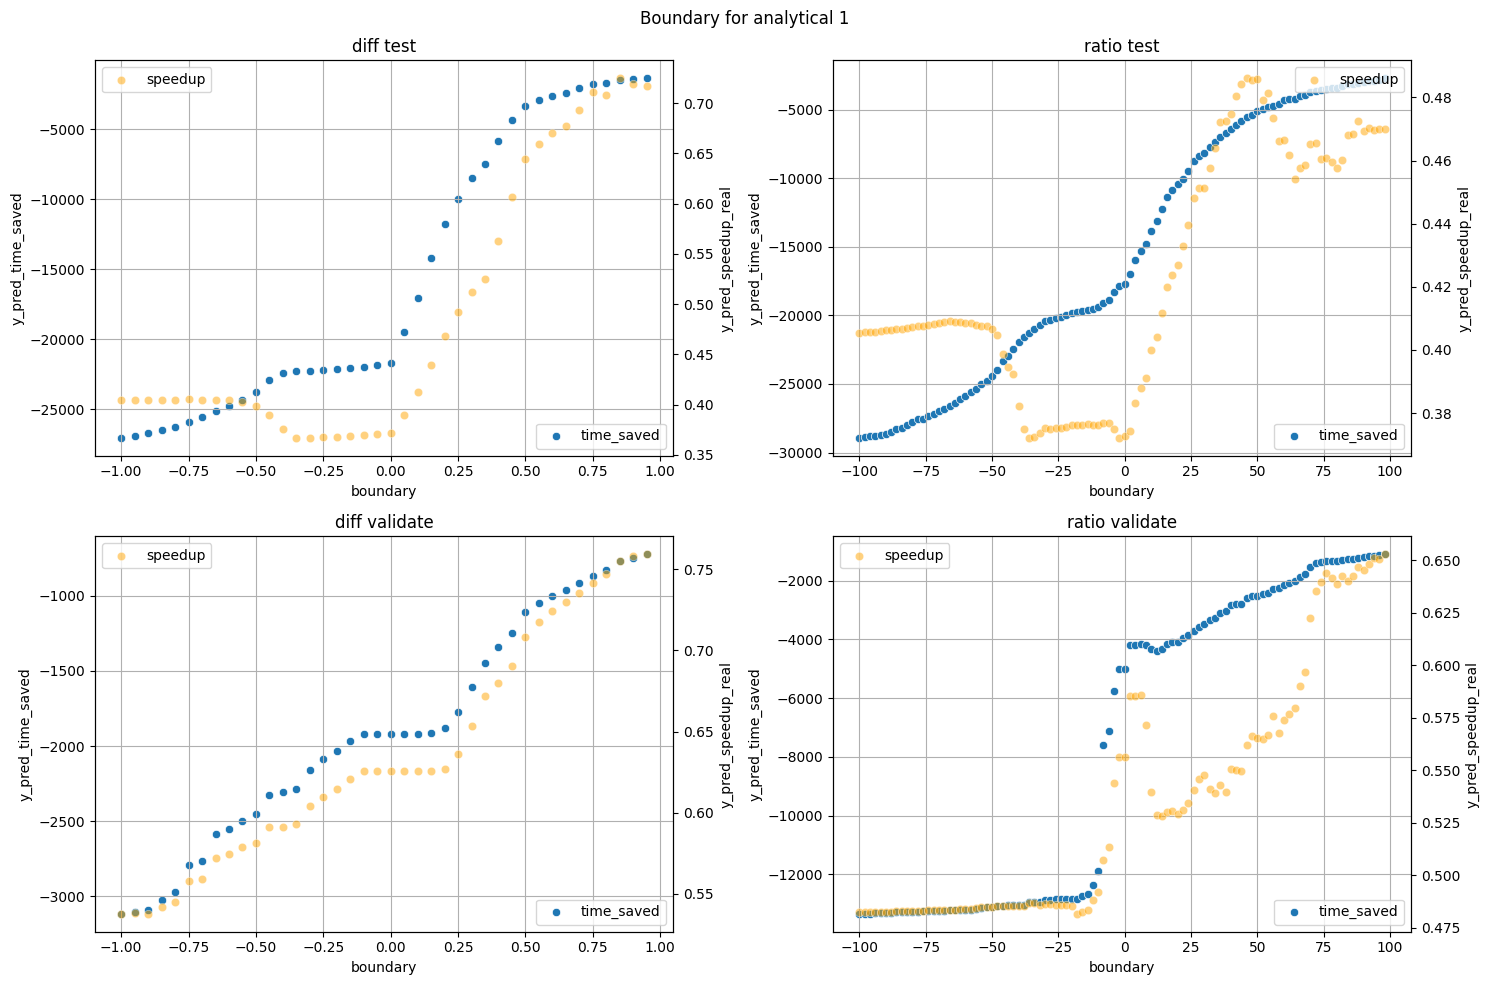

In [33]:
# loc =cost_df.dataset_type != 'synthetic'
fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("Boundary for analytical 1")
for i, (ax, cost_df, full_df, type) in enumerate(zip(axs, [cost_test, cost_validate], [test, validate], ['test', 'validate'])):
    plot_boundary(full_df.time_saved, cost_df.cost_diff_1, lower=-1,  upper=1, step=0.05, target_col=None, full_dataset=full_df, ax=ax[0])
    plot_boundary(full_df.time_saved, cost_df.cost_ratio_1, lower=-100,  upper=100, step=2, target_col=None, full_dataset=full_df, ax=ax[1])
    ax[0].set_title(f"diff {type}")
    ax[1].set_title(f"ratio {type}")
fig.tight_layout()

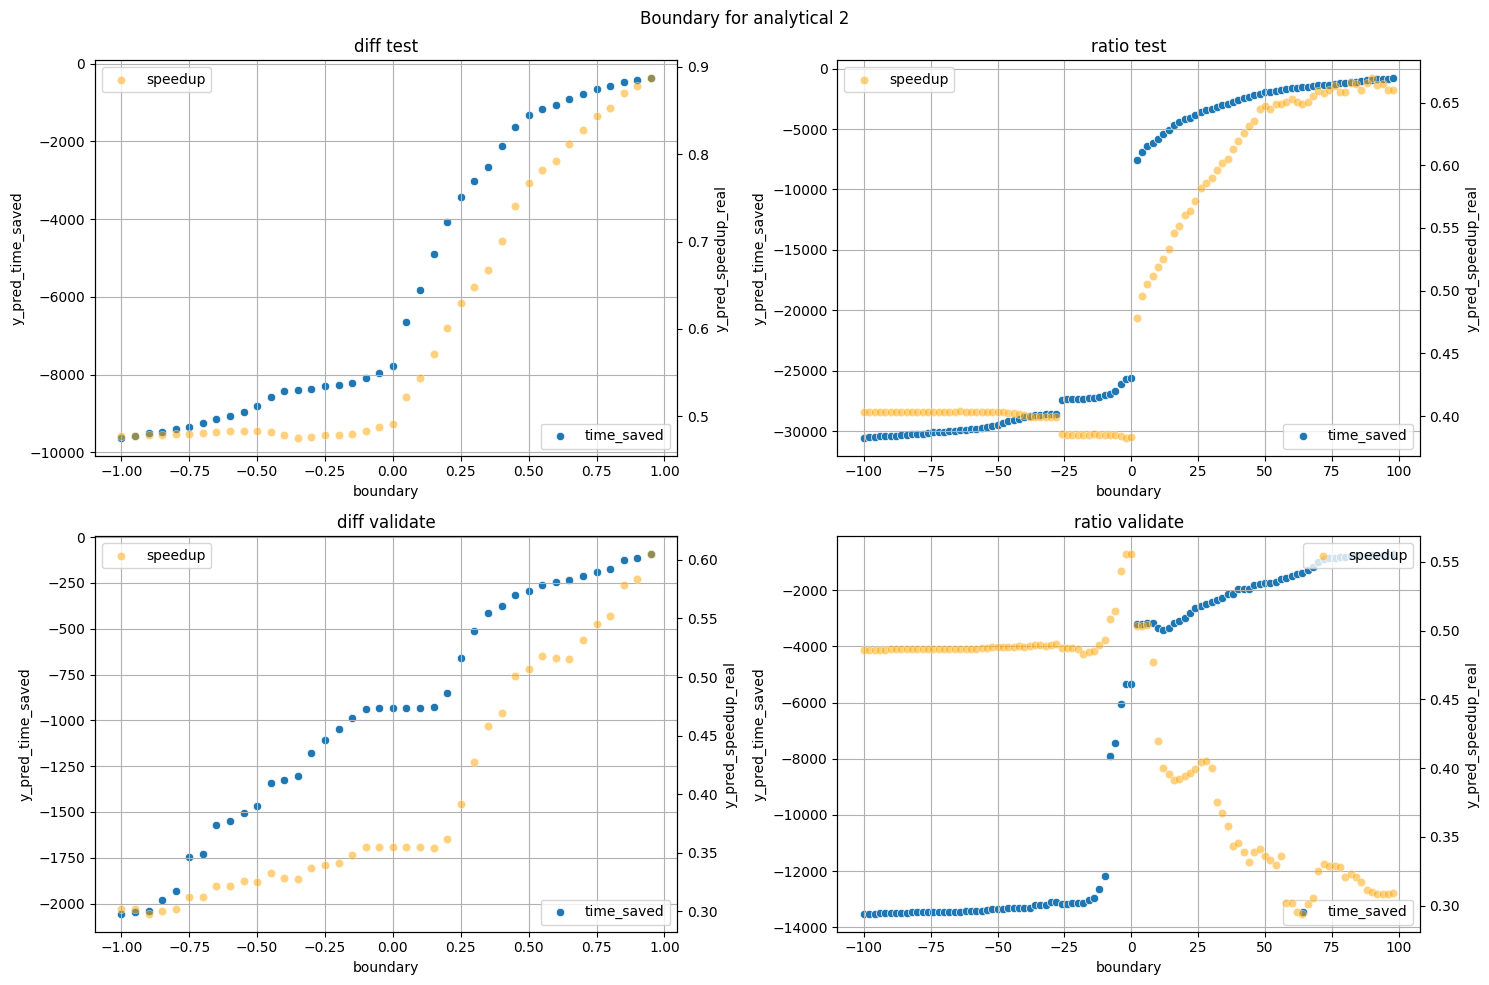

In [34]:
# loc =cost_df.dataset_type != 'synthetic'
fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("Boundary for analytical 2")
for i, (ax, cost_df, full_df, type) in enumerate(zip(axs, [cost_test, cost_validate], [test, validate], ['test', 'validate'])):
    plot_boundary(full_df.time_saved, cost_df.cost_diff_2, lower=-1,  upper=1, step=0.05, target_col=None, full_dataset=full_df, ax=ax[0])
    plot_boundary(full_df.time_saved, cost_df.cost_ratio_2, lower=-100,  upper=100, step=2, target_col=None, full_dataset=full_df, ax=ax[1])
    ax[0].set_title(f"diff {type}")
    ax[1].set_title(f"ratio {type}")
fig.tight_layout()

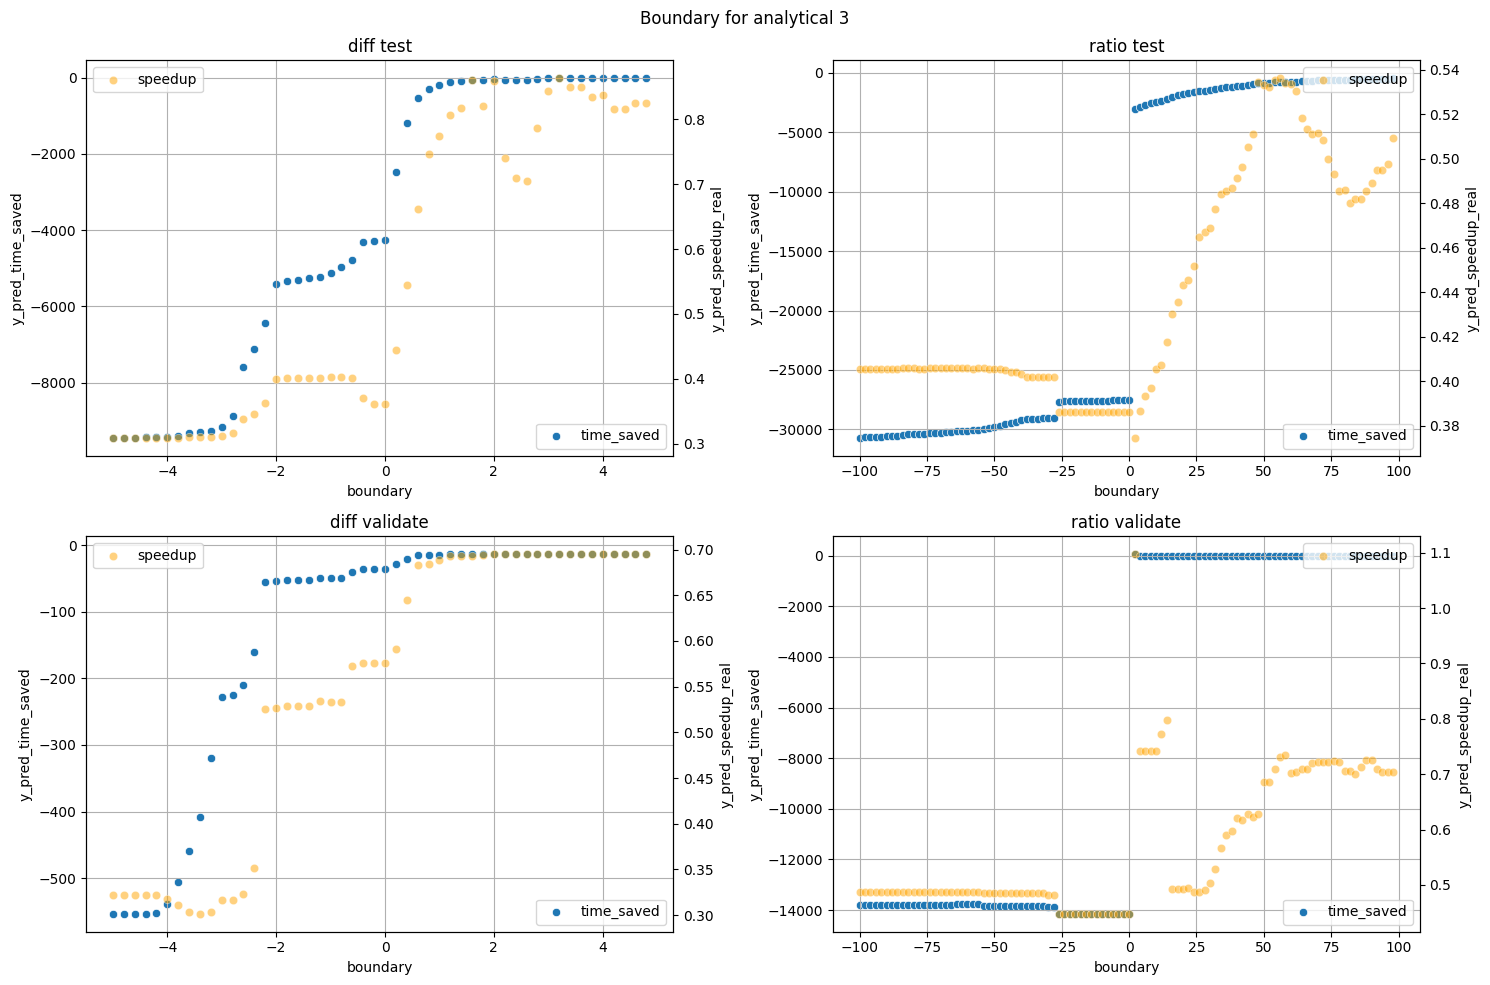

In [36]:
# loc =cost_df.dataset_type != 'synthetic'
fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("Boundary for analytical 3")
for i, (ax, cost_df, full_df, type) in enumerate(zip(axs, [cost_test, cost_validate], [test, validate], ['test', 'validate'])):
    plot_boundary(full_df.time_saved, cost_df.cost_diff_3, lower=-5,  upper=5, step=0.2, target_col=None, full_dataset=full_df, ax=ax[0])
    plot_boundary(full_df.time_saved, cost_df.cost_ratio_3, lower=-100,  upper=100, step=2, target_col=None, full_dataset=full_df, ax=ax[1])
    ax[0].set_title(f"diff {type}")
    ax[1].set_title(f"ratio {type}")
fig.tight_layout()

In [45]:
# Apply the same operations to cost_test and cost_validate
cost_test['mem_fac_sum'] = test.mem_fac_read + test.mem_fac_write
cost_test['mem_mat_sum'] = test.mem_mat_read + test.mem_mat_write
cost_test['mem_diff'] = (test.mem_mat_sum - test.mem_fac_sum)/4e10
cost_test['mem_ratio'] = test.mem_mat_sum / test.mem_fac_sum
cost_test.mem_diff.describe()

cost_validate['mem_fac_sum'] = validate.mem_fac_read + validate.mem_fac_write
cost_validate['mem_mat_sum'] = validate.mem_mat_read + validate.mem_mat_write
cost_validate['mem_diff'] = (validate.mem_mat_sum - validate.mem_fac_sum)/4e10
cost_validate['mem_ratio'] = validate.mem_mat_sum / validate.mem_fac_sum
cost_validate.mem_diff.describe()

count    11187.000000
mean         1.691918
std          5.376524
min         -7.661454
25%         -0.000200
50%          0.172807
75%          1.434072
max        104.050591
Name: mem_diff, dtype: float64

In [57]:
 test.mem_ratio.describe()

count    20295.000000
mean         2.781730
std          2.502215
min          0.500022
25%          0.969103
50%          1.568290
75%          4.007841
max          9.580602
Name: mem_ratio, dtype: float64

<Axes: xlabel='mem_diff', ylabel='Density'>

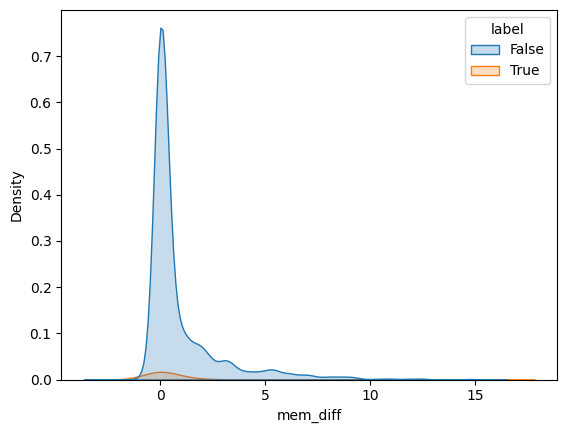

In [75]:
sns.kdeplot(data=test[test.compute_type=='gpu'], x='mem_diff', hue='label', fill=True)

(0.0, 15.0)

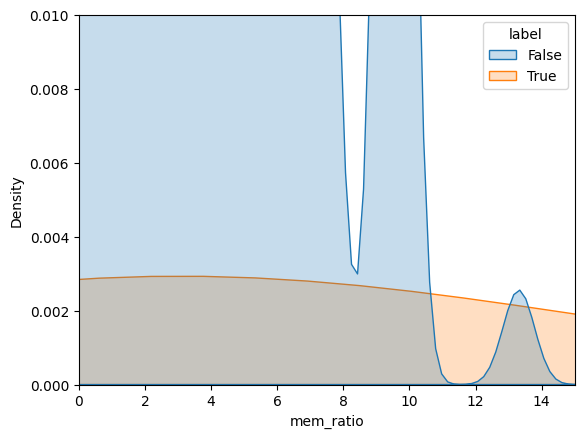

In [77]:
ax = sns.kdeplot(data=validate[validate.compute_type=='gpu'], x='mem_ratio', hue='label', fill=True)
ax.set_ylim(0, 0.01)
ax.set_xlim(0, 15)

In [83]:
# Assuming validate and test are your DataFrame names
validate_high_mem_ratio = validate[validate['mem_ratio'] > 10]

print("Validate DataFrame characteristics where mem_ratio > 10:")
display(validate_high_mem_ratio.describe())

print("\nTest DataFrame characteristics")
display(test.describe())


Validate DataFrame characteristics where mem_ratio > 10:


speedup   num_cores  selectivity  cardinality_T  cardinality_S  \
count  384.000000  384.000000   384.000000   3.840000e+02     384.000000   
mean     2.549376    6.375000     0.451711   3.945294e+05  105809.208333   
std      3.463857   11.327777     0.473688   3.722009e+05  155170.772397   
min      0.056361   -1.000000     0.007795   6.654800e+04    2966.000000   
25%      0.763341   -1.000000     0.035863   6.654800e+04    7797.000000   
50%      1.200571   -1.000000     0.230997   2.158790e+05   49867.500000   
75%      2.663762   10.000000     1.005657   5.662298e+05   73425.000000   
max     23.972204   32.000000     1.103339   1.000209e+06  423955.000000   

       complexity_ratio  times_mean  mem_mat_read  mem_mat_write  \
count        384.000000  384.000000  3.840000e+02   3.840000e+02   
mean           1.523329    1.408442  7.877532e+10   1.386771e+07   
std            0.441205    2.331312  1.074176e+11   2.543172e+07   
min            0.952216    0.084906  1.882510e+09   5.898400e+05   
25%            1.002466    0.260266  4.157491e+09   1.789344e+06   
50%            1.626481    0.478745  3.548208e+10   3.679388e+06   
75%            1.934890    1.585655  8.848144e+10   1.013557e+07   
max            1.988822   18.309331  4.175595e+11   1.107434e+08   

       mem_fac_read  ...  gpu_memory_bandwidth  \
count  3.840000e+02  ...            240.000000   
mean   2.172540e+09  ...            685.600000   
std    2.208802e+09  ...            137.191336   
min    5.573928e+07  ...            484.000000   
25%    3.086041e+08  ...            616.000000   
50%    1.189681e+09  ...            696.000000   
75%    3.853894e+09  ...            732.000000   
max    7.496695e+09  ...            900.000000   

       gpu_processing_power_half_precision  \
count                           240.000000   
mean                             61.354000   
std                              58.735774   
min                               0.170000   
25%                              21.200000   
50%                              23.500000   
75%                             112.220000   
max                             149.680000   

       gpu_processing_power_single_precision  \
count                             240.000000   
mean                               16.882000   
std                                10.366495   
min                                10.600000   
25%                                10.610000   
50%                                11.750000   
75%                                14.030000   
max                                37.420000   

       gpu_processing_power_double_precision  materialized_times_mean  \
count                             240.000000               384.000000   
mean                                2.709380                 2.078686   
std                                 2.874252                 3.235278   
min                                 0.316800                 0.087255   
25%                                 0.331500                 0.291753   
50%                                 0.584600                 0.773175   
75%                                 5.300000                 2.452341   
max                                 7.014000                27.560106   

       time_saved   mem_fac_sum   mem_mat_sum    mem_diff   mem_ratio  
count  384.000000  3.840000e+02  3.840000e+02  384.000000  384.000000  
mean     0.670245  2.174459e+09  7.878919e+10    1.915368   59.807815  
std      3.325771  2.209984e+09  1.074372e+11    2.681352   87.706220  
min    -16.221876  5.582046e+07  1.883100e+09    0.045682   11.479837  
25%     -0.160566  3.093008e+08  4.158133e+09    0.096221   12.963676  
50%      0.067423  1.190170e+09  3.548486e+10    0.817431   13.443651  
75%      1.153013  3.854782e+09  8.851111e+10    2.045662   34.013870  
max     24.255383  7.497065e+09  4.176702e+11   10.398543  241.663525  

[8 rows x 69 columns]


Test DataFrame characteristics


speedup     num_cores   selectivity   cardinality_T  \
count  20295.000000  20295.000000  20295.000000    20295.000000   
mean       0.495585      7.464893      1.113280   503506.318453   
std        0.472085     11.736557      0.210233   352533.702632   
min        0.004223     -1.000000      1.000000    60000.000000   
25%        0.270260     -1.000000      1.000002   100000.000000   
50%        0.368169     -1.000000      1.033330   500000.000000   
75%        0.593051     16.000000      1.122220   971428.000000   
max       10.846764     32.000000      2.000000  1000000.000000   

       cardinality_S  complexity_ratio    times_mean  mem_mat_read  \
count   2.029500e+04      20295.000000  20295.000000  2.029500e+04   
mean    5.642895e+05          1.224559      2.577850  7.225931e+10   
std     4.227624e+05          0.339576      4.540900  1.088302e+11   
min     6.000000e+04          0.600000      0.044314  1.616052e+08   
25%     1.122220e+05          0.950177      0.281738  6.217363e+09   
50%     5.166670e+05          1.165076      0.920914  2.580072e+10   
75%     9.766670e+05          1.546790      2.849191  9.066704e+10   
max     2.000000e+06          1.957492     56.210350  6.978793e+11   

       mem_mat_write  mem_fac_read  ...  gpu_memory_bandwidth  \
count   2.029500e+04  2.029500e+04  ...          11548.000000   
mean    1.506567e+07  3.300012e+10  ...            676.470731   
std     2.737408e+07  5.424710e+10  ...            150.685813   
min     4.800800e+05  2.121176e+08  ...            484.000000   
25%     2.053043e+06  2.573551e+09  ...            616.000000   
50%     6.373576e+06  1.532470e+10  ...            696.000000   
75%     1.241952e+07  4.012649e+10  ...            900.000000   
max     1.840012e+08  6.280914e+11  ...            900.000000   

       gpu_processing_power_half_precision  \
count                         11548.000000   
mean                             72.041774   
std                              61.362465   
min                               0.170000   
25%                              23.500000   
50%                             112.220000   
75%                             149.680000   
max                             149.680000   

       gpu_processing_power_single_precision  \
count                           11548.000000   
mean                               18.479505   
std                                11.012317   
min                                10.610000   
25%                                11.750000   
50%                                14.030000   
75%                                37.420000   
max                                37.420000   

       gpu_processing_power_double_precision  materialized_times_mean  \
count                           11548.000000             20295.000000   
mean                                2.093569                 1.043690   
std                                 2.878984                 1.887256   
min                                 0.316800                 0.018144   
25%                                 0.316800                 0.103928   
50%                                 0.584600                 0.333574   
75%                                 7.014000                 1.048041   
max                                 7.014000                15.548652   

         time_saved   mem_fac_sum   mem_mat_sum      mem_diff     mem_ratio  
count  20295.000000  2.029500e+04  2.029500e+04  20295.000000  20295.000000  
mean      -1.534161  3.301136e+10  7.227438e+10      0.981575      2.781730  
std        3.541849  5.425955e+10  1.088507e+11      2.059971      2.502215  
min      -43.228828  2.127017e+08  1.621892e+08     -2.709363      0.500022  
25%       -1.501056  2.574798e+09  6.223203e+09     -0.001109      0.969103  
50%       -0.404881  1.533284e+10  2.580872e+10      0.113103      1.568290  
75%       -0.081542  4.014249e+10  9.067104e+10      1.027198      4.007841  
max        8.932996  6.282714e+11  6.980633e+11     15.623221

In [79]:
validate[validate.mem_ratio > 10].describe()

speedup   num_cores  selectivity  cardinality_T  cardinality_S  \
count  384.000000  384.000000   384.000000   3.840000e+02     384.000000   
mean     2.549376    6.375000     0.451711   3.945294e+05  105809.208333   
std      3.463857   11.327777     0.473688   3.722009e+05  155170.772397   
min      0.056361   -1.000000     0.007795   6.654800e+04    2966.000000   
25%      0.763341   -1.000000     0.035863   6.654800e+04    7797.000000   
50%      1.200571   -1.000000     0.230997   2.158790e+05   49867.500000   
75%      2.663762   10.000000     1.005657   5.662298e+05   73425.000000   
max     23.972204   32.000000     1.103339   1.000209e+06  423955.000000   

       complexity_ratio  times_mean  mem_mat_read  mem_mat_write  \
count        384.000000  384.000000  3.840000e+02   3.840000e+02   
mean           1.523329    1.408442  7.877532e+10   1.386771e+07   
std            0.441205    2.331312  1.074176e+11   2.543172e+07   
min            0.952216    0.084906  1.882510e+09   5.898400e+05   
25%            1.002466    0.260266  4.157491e+09   1.789344e+06   
50%            1.626481    0.478745  3.548208e+10   3.679388e+06   
75%            1.934890    1.585655  8.848144e+10   1.013557e+07   
max            1.988822   18.309331  4.175595e+11   1.107434e+08   

       mem_fac_read  ...  gpu_memory_bandwidth  \
count  3.840000e+02  ...            240.000000   
mean   2.172540e+09  ...            685.600000   
std    2.208802e+09  ...            137.191336   
min    5.573928e+07  ...            484.000000   
25%    3.086041e+08  ...            616.000000   
50%    1.189681e+09  ...            696.000000   
75%    3.853894e+09  ...            732.000000   
max    7.496695e+09  ...            900.000000   

       gpu_processing_power_half_precision  \
count                           240.000000   
mean                             61.354000   
std                              58.735774   
min                               0.170000   
25%                              21.200000   
50%                              23.500000   
75%                             112.220000   
max                             149.680000   

       gpu_processing_power_single_precision  \
count                             240.000000   
mean                               16.882000   
std                                10.366495   
min                                10.600000   
25%                                10.610000   
50%                                11.750000   
75%                                14.030000   
max                                37.420000   

       gpu_processing_power_double_precision  materialized_times_mean  \
count                             240.000000               384.000000   
mean                                2.709380                 2.078686   
std                                 2.874252                 3.235278   
min                                 0.316800                 0.087255   
25%                                 0.331500                 0.291753   
50%                                 0.584600                 0.773175   
75%                                 5.300000                 2.452341   
max                                 7.014000                27.560106   

       time_saved   mem_fac_sum   mem_mat_sum    mem_diff   mem_ratio  
count  384.000000  3.840000e+02  3.840000e+02  384.000000  384.000000  
mean     0.670245  2.174459e+09  7.878919e+10    1.915368   59.807815  
std      3.325771  2.209984e+09  1.074372e+11    2.681352   87.706220  
min    -16.221876  5.582046e+07  1.883100e+09    0.045682   11.479837  
25%     -0.160566  3.093008e+08  4.158133e+09    0.096221   12.963676  
50%      0.067423  1.190170e+09  3.548486e+10    0.817431   13.443651  
75%      1.153013  3.854782e+09  8.851111e+10    2.045662   34.013870  
max     24.255383  7.497065e+09  4.176702e+11   10.398543  241.663525  

[8 rows x 69 columns]

In [55]:
validate.mem_diff.describe()

count    11187.000000
mean         1.691918
std          5.376524
min         -7.661454
25%         -0.000200
50%          0.172807
75%          1.434072
max        104.050591
Name: mem_diff, dtype: float64

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0

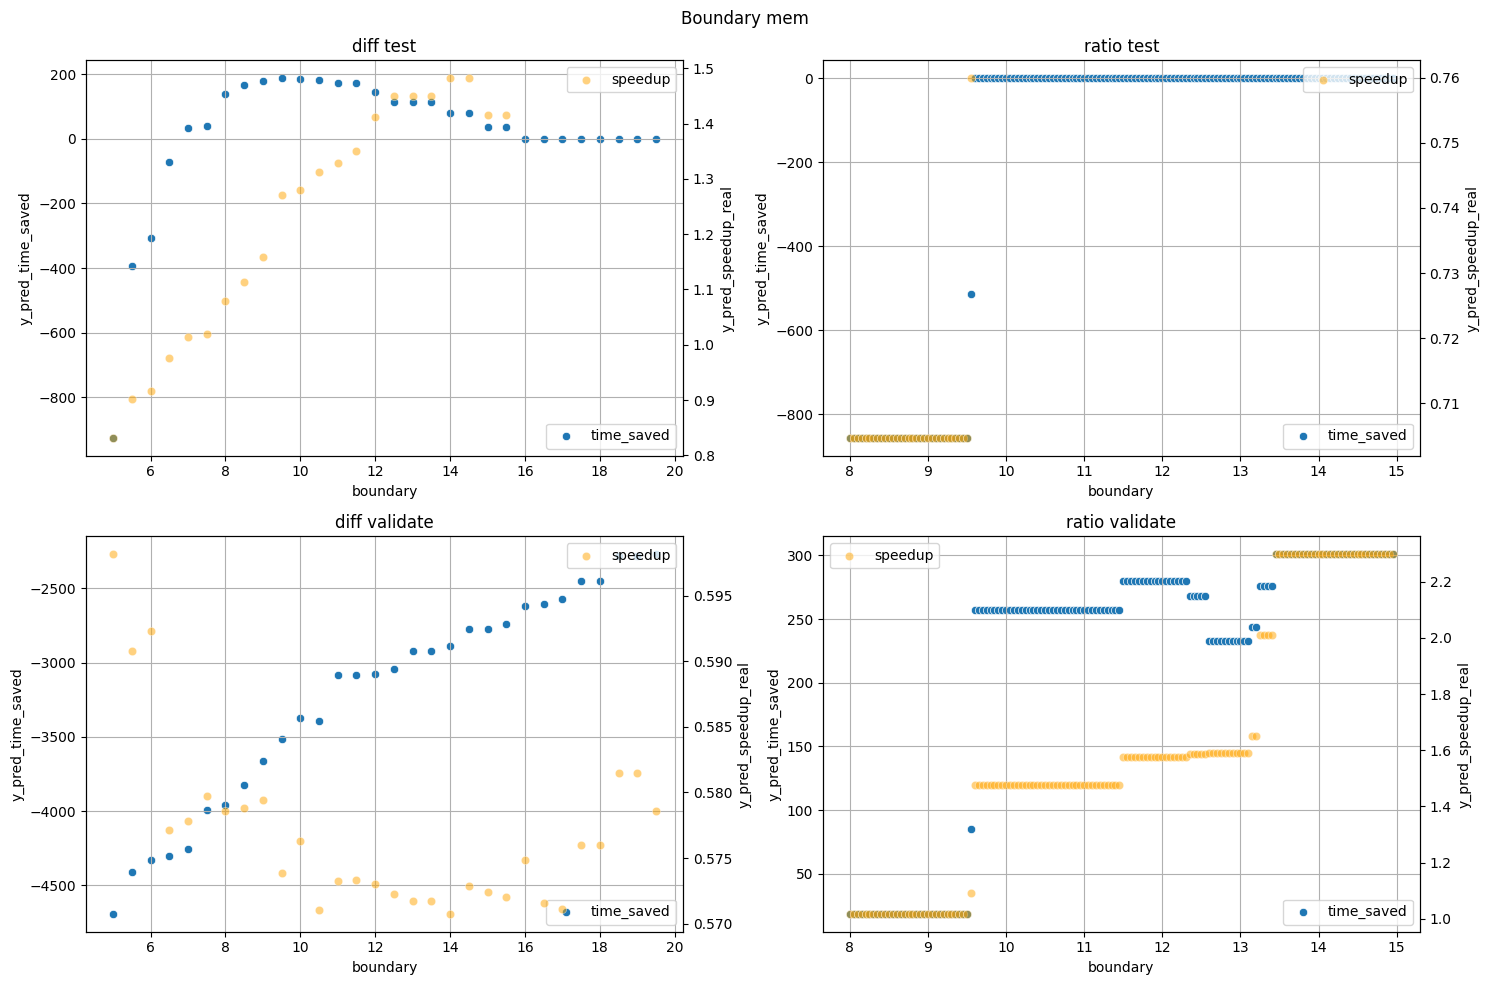

In [51]:
# loc =cost_df.dataset_type != 'synthetic'
fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("Boundary mem")
for i, (ax, cost_df, full_df, type) in enumerate(zip(axs, [cost_test, cost_validate], [test, validate], ['test', 'validate'])):
    plot_boundary(full_df.time_saved, cost_df.mem_diff, lower=5,  upper=20, step=0.5, target_col=None, full_dataset=full_df, ax=ax[0])
    plot_boundary(full_df.time_saved, cost_df.mem_ratio, lower=8,  upper=15, step=0.05, target_col=None, full_dataset=full_df, ax=ax[1])
    ax[0].set_title(f"diff {type}")
    ax[1].set_title(f"ratio {type}")
fig.tight_layout()

<Figure size 1200x600 with 0 Axes>

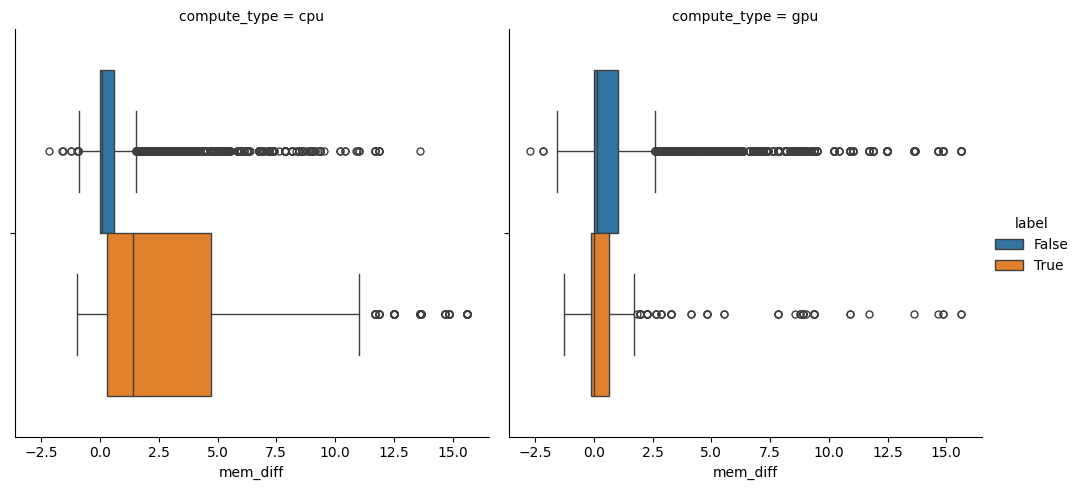

<Figure size 1200x600 with 0 Axes>

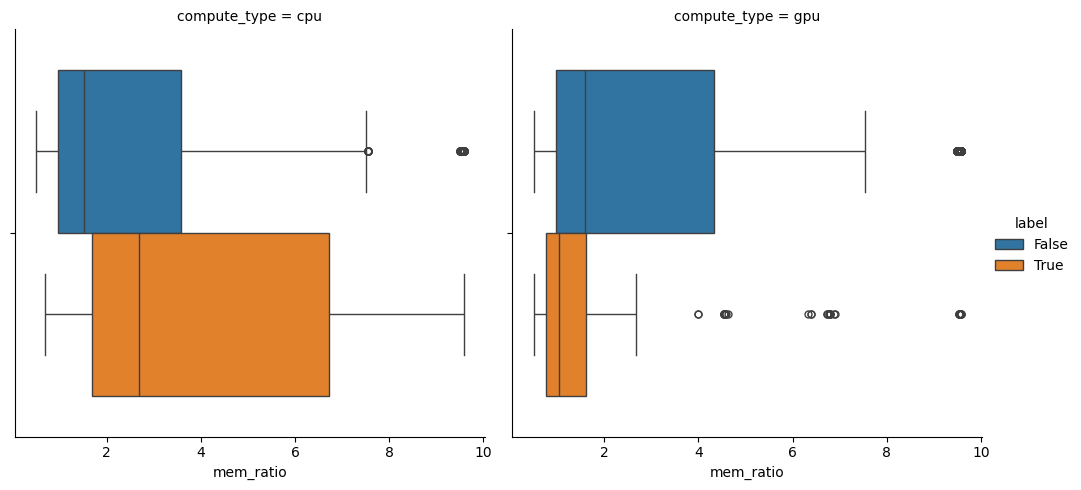

<Figure size 1200x600 with 0 Axes>

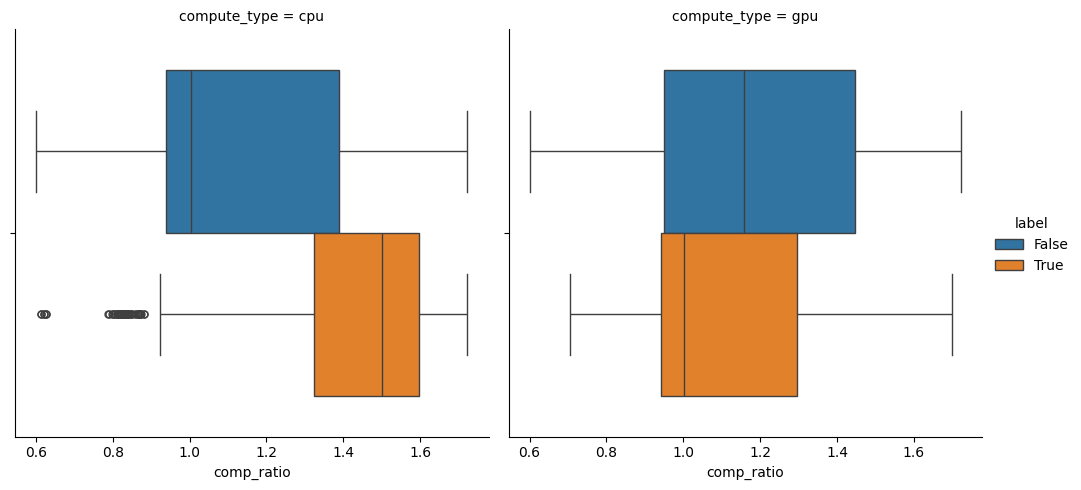

In [97]:
# Assuming that your DataFrame is named 'df' and it has columns 'mem_ratio', 'comp_ratio', 'label' and 'device'
# Plotting distribution of mem_ratio for true/false labels and split by device
plt.figure(figsize=(12, 6))
sns.catplot(data=test, kind='box', x="mem_diff", hue="label", col="compute_type",)
# plt.title('Distribution of mem_ratio for True/False Labels split by device')
plt.show()
# Plotting distribution of mem_ratio for true/false labels and split by device
plt.figure(figsize=(12, 6))
sns.catplot(data=test, kind='box', x="mem_ratio", hue="label", col="compute_type",)
# plt.title('Distribution of mem_ratio for True/False Labels split by device')
plt.show()

# Plotting distribution of comp_ratio for true/false labels and split by device
plt.figure(figsize=(12, 6))
sns.catplot(data=test,kind='box', x="comp_ratio", hue="label", col="compute_type")
# plt.title('Distribution of comp_ratio for True/False Labels split by device')
plt.show()

In [114]:
X.select_dtypes(exclude='number')

c_S          morpheusfi_eis
78800    [4, 40]                   [0.0]
318857  [15, 21]  [0.028566095344759002]
343270   [1, 10]                   [0.0]
190884  [30, 50]     [0.059999849999999]
143696  [12, 16]                   [0.0]
...          ...                     ...
223691  [10, 45]   [0.11110361120485901]
21960    [3, 30]     [0.033332833335833]
110313  [10, 50]     [0.159995294117647]
3561     [5, 10]                   [0.0]
127096   [4, 20]                   [0.0]

[20295 rows x 2 columns]

In [147]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import StratifiedKFold

# Define the target variable
y = test.label

# Drop the target variable from the input DataFrame
X = test.drop(
    columns=[
        "operator",
        "num_cores",
        "join",
        "time_saved",
        "materialized_times_mean",
        "label",
        "times_mean",
        "parallelism",
        "gpu__architecture",
        "r_S",
        "nnz_S",
        "sparsity_S",
        "morpheusfi_nis",
        "c_S",
        "morpheusfi_eis",
        "speedup",
    ]
)
X["compute_type"] = X["compute_type"].map({"cpu": 0, "gpu": 1})
# Perform feature selection
# Create a Decision Tree Classifier
tree = DecisionTreeClassifier()

# Create the RFE object and compute a cross-validated score.
rfecv = RFE(estimator=tree, n_features_to_select=5)

# Fit the data to the rfecv object
rfecv.fit(X, y)

# Print the optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

# Print the ranking of features
print("Feature ranking:", rfecv.ranking_)

Optimal number of features : 5
Feature ranking: [20 52 24 19 21  1 27 22 15 29 23 48 31  1 57 12 14 25 56 53 38 18 35 16
 45 50 49 51 47 55 58 60 59  1  8  1 37 40 30  9  7  3 43  6  4 61 54 41
 42 28 46 36 13 33 44 34  5 39  2 17 32 11 26  1 10]


In [138]:
rfecv.get_feature_names_out()

array(['comp_lmm_fac', 'comp_mat', 'comp_ratio', 'gpu__cores', 'mem_diff'],
      dtype=object)

In [150]:
X = validate.drop(
    columns=[
        "operator",
        "num_cores",
        "join",
        "time_saved",
        "materialized_times_mean",
        "label",
        "times_mean",
        "parallelism",
        "gpu__architecture",
        "r_S",
        "nnz_S",
        "sparsity_S",
        "morpheusfi_nis",
        "c_S",
        "morpheusfi_eis",
        "speedup",
    ]
)
y=validate.label
X["compute_type"] = X["compute_type"].map({"cpu": 0, "gpu": 1})


eval_result(y, t.predict(X[features]), full_dataset=validate)

({'accuracy': 0.8845088048627872,
  'precision': 0.07960199004975124,
  'recall': 0.014247551202137132,
  'f1': 0.02416918429003021,
  'speedup': {'y_true_mat_time': 2792.661280960886,
   'y_true_fact_time': 1125.213198860922,
   'y_true_best_time': 1125.213198860922,
   'y_true_time_saved': 1667.448082099964,
   'y_true_speedup_avg': 4.016881640634372,
   'y_true_speedup_real': 2.481895238864918,
   'y_pred_mat_time': 4455.533774328127,
   'y_pred_fact_time': 8086.42113424892,
   'y_pred_best_time': 4434.1512744434085,
   'y_pred_time_saved': -3630.8873599207927,
   'y_pred_speedup_avg': 0.6595768662475369,
   'y_pred_speedup_real': 0.550989578746688,
   'TP': (16, 1.3808523689612628),
   'FP': (185, 0.5971962822290525),
   'TN': (9879, 0.3724622430229557),
   'FN': (1107, 4.054981431372195)}},
 None,
 {'y_true_mat_time': 2792.661280960886,
  'y_true_fact_time': 1125.213198860922,
  'y_true_best_time': 1125.213198860922,
  'y_true_time_saved': 1667.448082099964,
  'y_true_speedup_avg'

({'accuracy': 0.9257945306725794,
  'precision': 0.7300613496932515,
  'recall': 0.07526881720430108,
  'f1': 0.13646788990825687,
  'speedup': {'y_true_mat_time': 4675.457687211972,
   'y_true_fact_time': 3222.5951272408565,
   'y_true_best_time': 3222.5951272408565,
   'y_true_time_saved': 1452.8625599711158,
   'y_true_speedup_avg': 1.6600671791388428,
   'y_true_speedup_real': 1.4508362057926394,
   'y_pred_mat_time': 1369.5488277795052,
   'y_pred_fact_time': 1152.017074979247,
   'y_pred_best_time': 1062.8209747563428,
   'y_pred_time_saved': 217.53175280025835,
   'y_pred_speedup_avg': 1.3491082494476825,
   'y_pred_speedup_real': 1.1888268477306876,
   'TP': (119, 1.5389465296860174),
   'FP': (44, 0.8356819915303668),
   'TN': (18670, 0.3961739943718716),
   'FN': (1462, 1.6699258366524448)}},
 None,
 {'y_true_mat_time': 4675.457687211972,
  'y_true_fact_time': 3222.5951272408565,
  'y_true_best_time': 3222.5951272408565,
  'y_true_time_saved': 1452.8625599711158,
  'y_true_sp

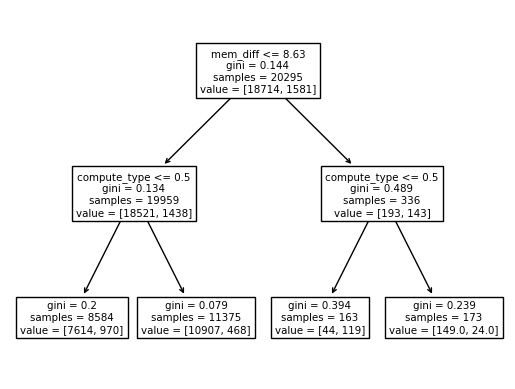

In [148]:
y = test.label

# Drop the target variable from the input DataFrame
X = test.drop(
    columns=[
        "operator",
        "num_cores",
        "join",
        "time_saved",
        "materialized_times_mean",
        "label",
        "times_mean",
        "parallelism",
        "gpu__architecture",
        "r_S",
        "nnz_S",
        "sparsity_S",
        "morpheusfi_nis",
        "c_S",
        "morpheusfi_eis",
        "speedup",
    ]
)
X["compute_type"] = X["compute_type"].map({"cpu": 0, "gpu": 1})

t = DecisionTreeClassifier(max_depth=2)
features = ['comp_ratio', 'mem_diff', 'mem_ratio', 'compute_type']
t.fit(X[features], y)
plot_tree(t, feature_names=features)
eval_result(y, t.predict(X[features]), full_dataset=test)

In [145]:
eval_result(y, t.predict(X[features]), full_dataset=validate)

({'accuracy': 0.9133816036470904,
  'precision': 0.8208333333333333,
  'recall': 0.17542297417631345,
  'f1': 0.289068231841526,
  'speedup': {'y_true_mat_time': 2792.661280960886,
   'y_true_fact_time': 1125.213198860922,
   'y_true_best_time': 1125.213198860922,
   'y_true_time_saved': 1667.448082099964,
   'y_true_speedup_avg': 4.016881640634372,
   'y_true_speedup_real': 2.481895238864918,
   'y_pred_mat_time': 513.4413318166766,
   'y_pred_fact_time': 119.8424370538619,
   'y_pred_best_time': 118.68175835546964,
   'y_pred_time_saved': 393.59889476281467,
   'y_pred_speedup_avg': 3.6290998714387297,
   'y_pred_speedup_real': 4.284303160373114,
   'TP': (197, 4.225406389468514),
   'FP': (43, 0.8971839632557629),
   'TN': (10021, 0.37435953503803576),
   'FN': (926, 3.972519464046546)}},
 None,
 {'y_true_mat_time': 2792.661280960886,
  'y_true_fact_time': 1125.213198860922,
  'y_true_best_time': 1125.213198860922,
  'y_true_time_saved': 1667.448082099964,
  'y_true_speedup_avg': 4.

In [ ]:
# Assuming that your DataFrame is named 'df' and it has columns 'mem_ratio', 'comp_ratio', 'label' and 'device'

# Plotting distribution of mem_ratio for true/false labels and split by device
plt.figure(figsize=(12, 6))
sns.histplot(data=test, x="mem_ratio", hue="label", col="device", element="step", stat="density", common_norm=False)
plt.title('Distribution of mem_ratio for True/False Labels split by device')
plt.show()

# Plotting distribution of comp_ratio for true/false labels and split by device
plt.figure(figsize=(12, 6))
sns.histplot(data=test, x="comp_ratio", hue="label", col="device", element="step", stat="density", common_norm=False)
plt.title('Distribution of comp_ratio for True/False Labels split by device')
plt.show()


In [ ]:
r = eval_result(test.label, test.mem_ratio > 10, test, target_col='label')[0]['speedup']
r['y_pred_time_saved'] / r['y_true_time_saved']

0.011760103932437559

In [ ]:
r = eval_result(test.label, ((test.mem_ratio > 11)), test, target_col='label')[0]['speedup']
r['y_pred_time_saved'] / r['y_true_time_saved']

0.011700864504389799

In [ ]:
pd.DataFrame({f"analytical_y_true": validate.label, f"analytical_y_pred": validate.mem_ratio >10.}).to_csv(
        f"evaluation/predictions/analytical1_label.csv"
    )

In [ ]:
pd.DataFrame({f"analytical_y_true": validate.label, f"analytical_y_pred": (validate.mem_ratio >10.) & (validate.comp_ratio>1.5)}).to_csv(
        f"evaluation/predictions/analytical2_label.csv"
    )

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0

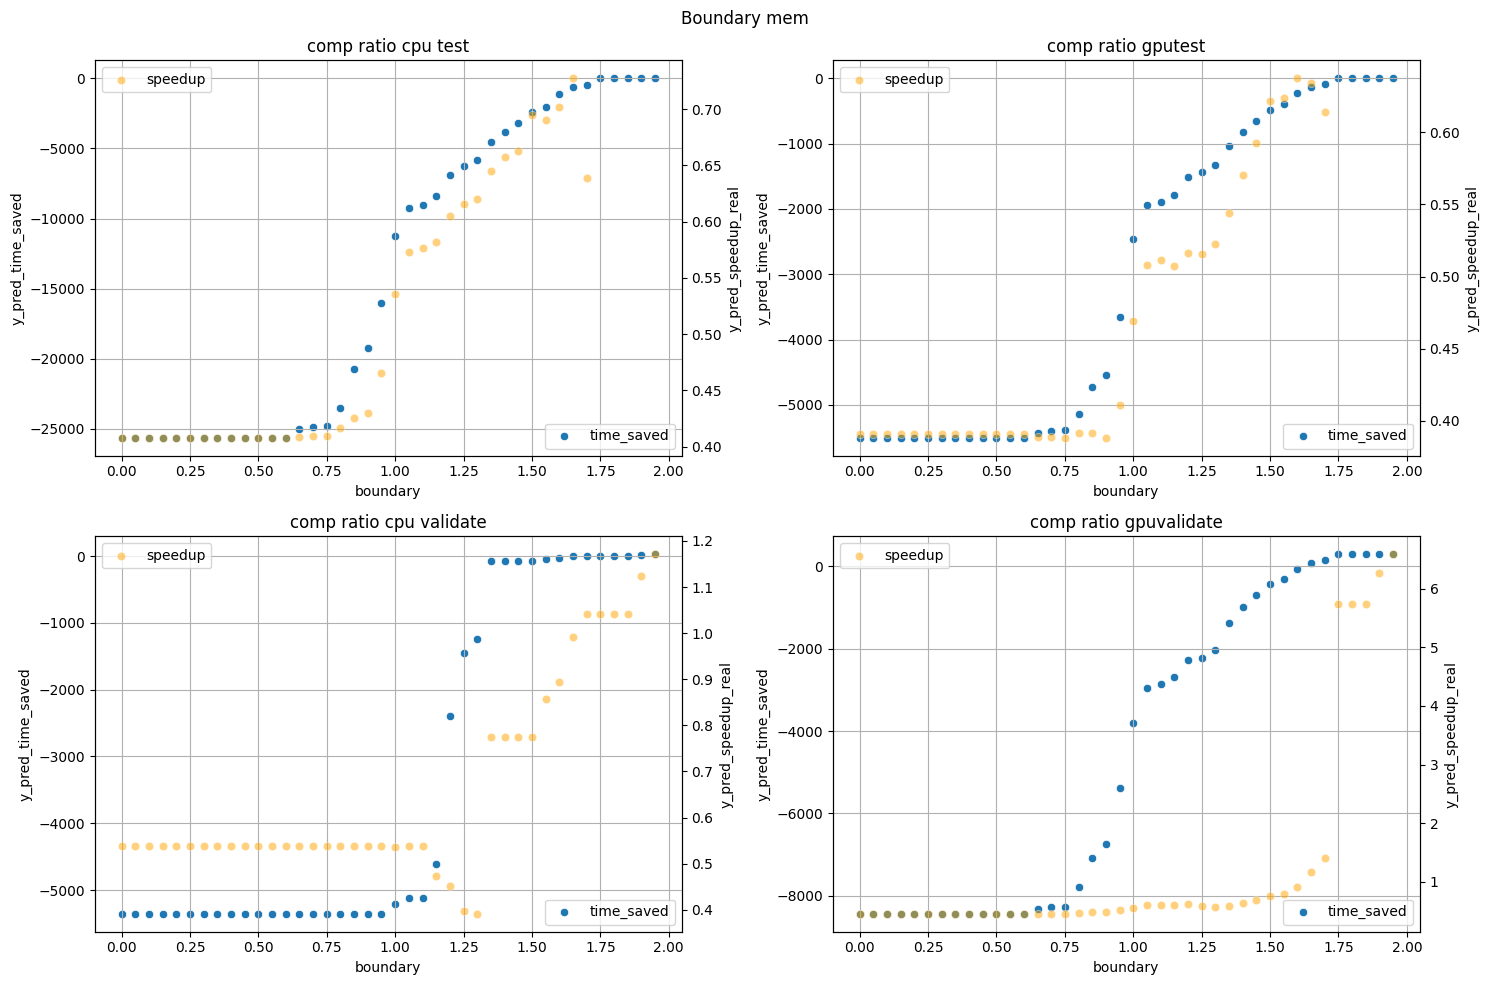

In [89]:
# loc =cost_df.dataset_type != 'synthetic'
fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("Boundary mem")
for i, (ax, cost_df, full_df, type) in enumerate(zip(axs, [cost_test, cost_validate], [test, validate], ['test', 'validate'])):
    loc = full_df[full_df.compute_type=='cpu'].index
    
    plot_boundary(full_df.loc[loc].time_saved, cost_df.loc[loc].comp_ratio, lower=0,  upper=2, step=0.05, target_col=None, full_dataset=full_df.loc[loc], ax=ax[0])
    
    loc = full_df[full_df.compute_type=='gpu'].index
    plot_boundary(full_df.loc[loc].time_saved, cost_df.loc[loc].comp_ratio, lower=0,  upper=2, step=0.05, target_col=None, full_dataset=full_df.loc[loc], ax=ax[1])
    ax[0].set_title(f"comp ratio cpu {type}")
    ax[1].set_title(f"comp ratio gpu {type}")
fig.tight_layout()

In [ ]:
# BEGIN: Adding new columns to cost_df
for i in range(1, 4):
    cost_df[f'analytical_cost_ratio_{i}'] = cost_test[f'cost_ratio_{i}']
# END: Adding new columns to cost_df


In [ ]:
np.linspace(cost_df["mem_ratio"].min(), cost_df["mem_ratio"].max(), 20)

array([  0.50002169,  13.19283767,  25.88565364,  38.57846962,
        51.27128559,  63.96410157,  76.65691755,  89.34973352,
       102.0425495 , 114.73536547, 127.42818145, 140.12099743,
       152.8138134 , 165.50662938, 178.19944535, 190.89226133,
       203.58507731, 216.27789328, 228.97070926, 241.66352523])

In [ ]:
cost_df.comp_ratio.describe()

count    49029.000000
mean         1.181548
std          0.294227
min          0.601594
25%          0.950574
50%          1.155220
75%          1.439104
max          1.987629
Name: comp_ratio, dtype: float64

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ParameterGrid
import numpy as np
from tqdm import tqdm

outer_results=[]
for i in range(1, 4):
    # Define the parameter grid for the search
    param_grid = {
        "mem_ratio": np.linspace(0.5, 10, 10),
        "comp_ratio": np.linspace(0.5, 2, 10),
        "loc": [cost_df.dataset_type == "synthetic", cost_df.dataset_type != "synthetic"],
    }
    col = cost_df[f"analytical_cost_ratio_{i}"]
    param_grid[f"analytical_cost_ratio_{i}"] = np.linspace(col.min(), col.max(), 20)
    



    # Create a list of dictionaries, each containing a unique combination of parameters
    grid = list(ParameterGrid(param_grid))

    # Initialize an empty list to store the results
    results = []

    # Perform grid search
    for params in tqdm(grid):
        mem_ratio = params["mem_ratio"]
        comp_ratio = params["comp_ratio"]

        loc = params["loc"]

        # Evaluate the result
        result = eval_result(
            cost_df.loc[loc].label,
            (
                (cost_df.loc[loc].mem_ratio > mem_ratio)
                & (cost_df.loc[loc].comp_ratio > comp_ratio)
                & (cost_df.loc[loc][col.name] > params[col.name])
            ),
            full_dataset=cost_df.loc[loc],
        )[0]
        result.update(params)
        # Append the result to the results list
        results.append(result)
    outer_results.append({f"analytical_cost_ratio_{i}": results})

  0%|          | 9/4000 [00:01<09:16,  7.17it/s]/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  1%|          | 28/4000 [00:02<06:53,  9.60it/s]/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  1%|          | 48/4000 [00:04<06:50,  9.63it/s]/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorizat

In [ ]:
cost_df[cost_df.dataset_type != "synthetic"].times_mean.sum()

1834.8690429897897

In [ ]:
cost_df[cost_df.dataset_type != "synthetic"].materialized_times_mean.sum()

2514.940036727597

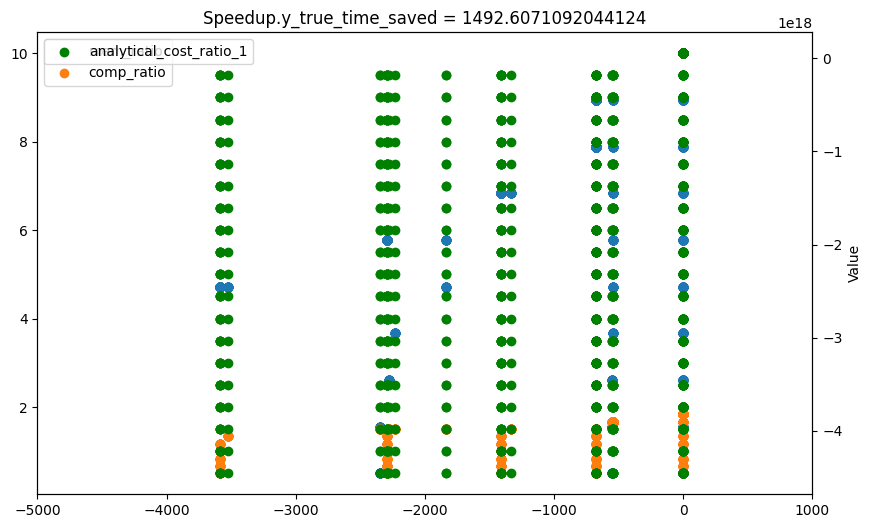

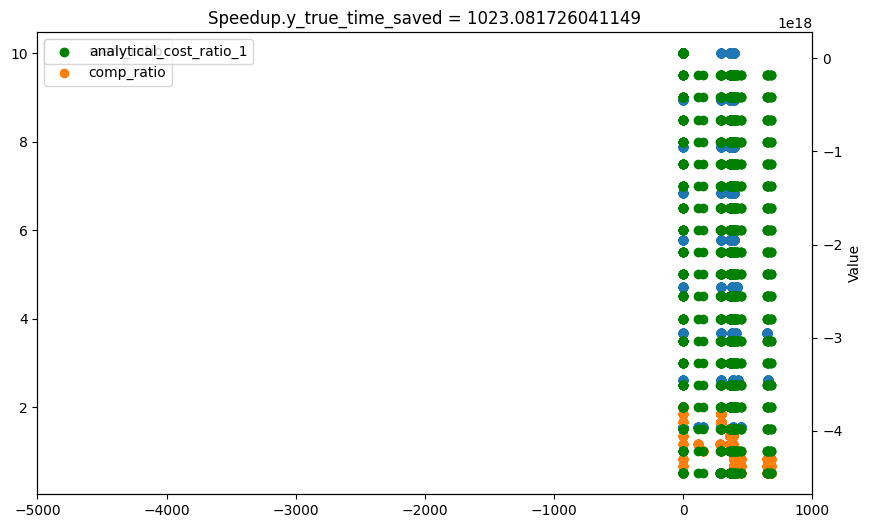

In [ ]:
dft = pd.json_normalize(pd.DataFrame(outer_results[0]).analytical_cost_ratio_1)
import matplotlib.pyplot as plt

# Assuming that 'speedup.y_pred_time_saved' is a column in the 'dft' DataFrame
unique_values = dft['speedup.y_true_time_saved'].unique()

for value in unique_values:
    subset = dft[dft['speedup.y_true_time_saved'] == value]
    
    plt.figure(figsize=(10, 6))
    
    plt.scatter(subset['speedup.y_pred_time_saved'], subset['mem_ratio'], label='mem_ratio')
    plt.scatter(subset['speedup.y_pred_time_saved'], subset['comp_ratio'], label='comp_ratio')
    plt.legend()
    plt.gca().twinx().scatter(subset['speedup.y_pred_time_saved'], subset['analytical_cost_ratio_1'], label='analytical_cost_ratio_1', color='green')
    plt.gca().set_xlim(-5000, 1000)
    plt.title(f'Speedup.y_true_time_saved = {value}')
    plt.xlabel('speedup.y_pred_time_saved')
    plt.ylabel('Value')
    plt.legend()
    
    plt.show()


In [ ]:
dft[(dft.mem_ratio > 4) & (dft.comp_ratio > 1.5) & (dft.analytical_cost_ratio_1 > -4e18)]

accuracy  precision    recall        f1  analytical_cost_ratio_1  \
544   0.926327   0.001389  0.000946  0.001125            -3.981710e+18   
545   0.926327   0.001389  0.000946  0.001125            -3.981710e+18   
546   0.926327   0.001389  0.000946  0.001125            -3.981710e+18   
547   0.926327   0.001389  0.000946  0.001125            -3.981710e+18   
548   0.926327   0.001389  0.000946  0.001125            -3.981710e+18   
...        ...        ...       ...       ...                      ...   
3995  0.297746   0.000000  0.000000  0.000000             5.403601e+16   
3996  0.297746   0.000000  0.000000  0.000000             5.403601e+16   
3997  0.297746   0.000000  0.000000  0.000000             5.403601e+16   
3998  0.297746   0.000000  0.000000  0.000000             5.403601e+16   
3999  0.297746   0.000000  0.000000  0.000000             5.403601e+16   

      comp_ratio                                                loc  \
544     1.666667  126644     True
126645     True
126646     Tru...   
545     1.666667  126644     True
126645     True
126646     Tru...   
546     1.666667  126644     True
126645     True
126646     Tru...   
547     1.666667  126644     True
126645     True
126646     Tru...   
548     1.666667  126644     True
126645     True
126646     Tru...   
...          ...                                                ...   
3995    2.000000  126644    False
126645    False
126646    Fals...   
3996    2.000000  126644    False
126645    False
126646    Fals...   
3997    2.000000  126644    False
126645    False
126646    Fals...   
3998    2.000000  126644    False
126645    False
126646    Fals...   
3999    2.000000  126644    False
126645    False
126646    Fals...   

      mem_ratio  speedup.y_true_mat_time  speedup.y_true_fact_time  ...  \
544    4.722222              2603.260862               1110.653753  ...   
545    5.777778              2603.260862               1110.653753  ...   
546    6.833333              2603.260862               1110.653753  ...   
547    7.888889              2603.260862               1110.653753  ...   
548    8.944444              2603.260862               1110.653753  ...   
...         ...                      ...                       ...  ...   
3995   5.777778              1465.354003                442.272277  ...   
3996   6.833333              1465.354003                442.272277  ...   
3997   7.888889              1465.354003                442.272277  ...   
3998   8.944444              1465.354003                442.272277  ...   
3999  10.000000              1465.354003                442.272277  ...   

      speedup.y_pred_mat_time  speedup.y_pred_fact_time  \
544                799.603011               1345.029442   
545                799.603011               1345.029442   
546                799.603011               1345.029442   
547                799.603011               1345.029442   
548                799.603011               1345.029442   
...                       ...                       ...   
3995                 0.000000                  0.000000   
3996                 0.000000                  0.000000   
3997                 0.000000                  0.000000   
3998                 0.000000                  0.000000   
3999                 0.000000                  0.000000   

      speedup.y_pred_best_time  speedup.y_pred_time_saved  \
544                 799.544978                -545.426431   
545                 799.544978                -545.426431   
546                 799.544978                -545.426431   
547                 799.544978                -545.426431   
548                 799.544978                -545.426431   
...                        ...                        ...   
3995                  0.000000                   0.000000   
3996                  0.000000                   0.000000   
3997                  0.000000                   0.000000   
3998                  0.000000              

In [ ]:
for r in outer_results:
    display(pd.json_normalize(pd.DataFrame(r)).head())

Empty DataFrame
Columns: []
Index: [0]

Empty DataFrame
Columns: []
Index: [0]

Empty DataFrame
Columns: []
Index: [0]

In [ ]:
pd.DataFrame(zip(grid, [r['speedup']['y_pred_time_saved'] for r in results])).sort_values(1)

0           1
1799  {'comp_ratio': 2.9000000000000004, 'mem_ratio'...    0.000000
1402  {'comp_ratio': 2.3000000000000003, 'mem_ratio'...    0.000000
1401  {'comp_ratio': 2.3000000000000003, 'mem_ratio'...    0.000000
1400  {'comp_ratio': 2.3000000000000003, 'mem_ratio'...    0.000000
1399  {'comp_ratio': 2.3000000000000003, 'mem_ratio'...    0.000000
...                                                 ...         ...
260               {'comp_ratio': 0.4, 'mem_ratio': 2.0}  701.350672
21                {'comp_ratio': 0.0, 'mem_ratio': 2.1}  701.350672
20                {'comp_ratio': 0.0, 'mem_ratio': 2.0}  701.350672
80                {'comp_ratio': 0.1, 'mem_ratio': 2.0}  701.350672
501               {'comp_ratio': 0.8, 'mem_ratio': 2.1}  701.350672

[1800 rows x 2 columns]

2024-03-29 11:00:26.786 | WARNING  | src.util:eval_result:570 - WARNING all predicted labels are the same: [ True]
2024-03-29 11:00:26.803 | WARNING  | src.util:eval_result:570 - WARNING all predicted labels are the same: [ True]


2024-03-29 11:00:26.819 | WARNING  | src.util:eval_result:570 - WARNING all predicted labels are the same: [ True]
2024-03-29 11:00:26.835 | WARNING  | src.util:eval_result:570 - WARNING all predicted labels are the same: [ True]
2024-03-29 11:00:26.855 | WARNING  | src.util:eval_result:570 - WARNING all predicted labels are the same: [ True]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-03-29 11:00:26.902 | WARNING  | src.util:eval_result:570 - WARNING all predicted labels are the same: [False]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

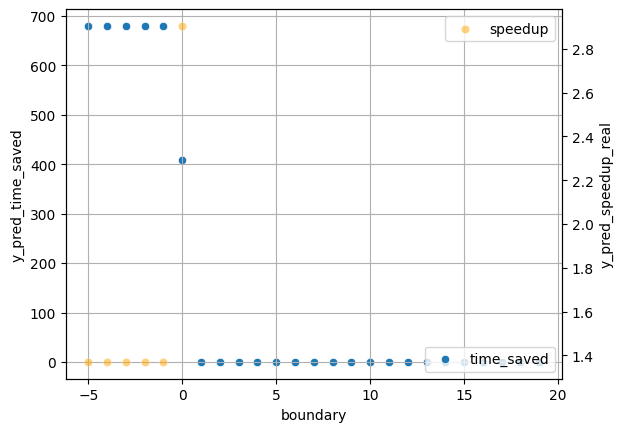

In [ ]:
pred = ((cost_df.loc[loc].mem_ratio > 2) & (cost_df.loc[loc].comp_ratio > 1)).astype(int)
plot_boundary(cost_df.loc[loc].speedup, pred, lower=-5,  upper=20, step=1, target_col='speedup', full_dataset=cost_df.loc[loc])

In [ ]:
# pred = ((cost_df.loc[loc].mem_ratio > 2) & 
#         (cost_df.loc[loc].comp_ratio > 1) & 
#         (cost_df.loc[loc].mem_diff > 0) &
#         (cost_df.loc[loc].cost_ratio_3 > 0)
#         )

AttributeError: 'DataFrame' object has no attribute 'cost_ratio_3'